In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [3]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [4]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

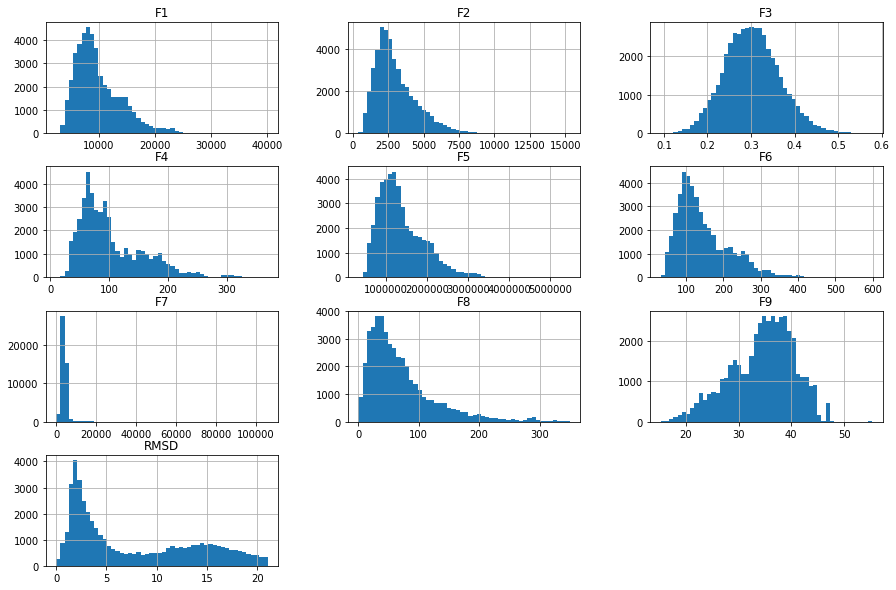

In [5]:
casp.hist(bins=50, figsize=(15,10));

Let us see if there is any missing data in the dataset

In [6]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [7]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

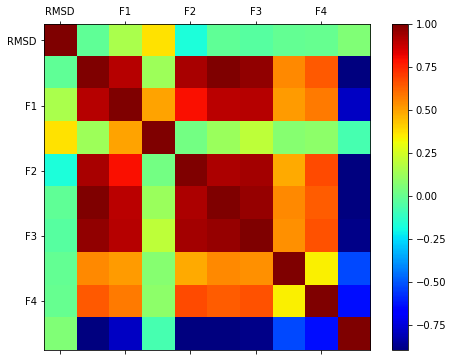

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

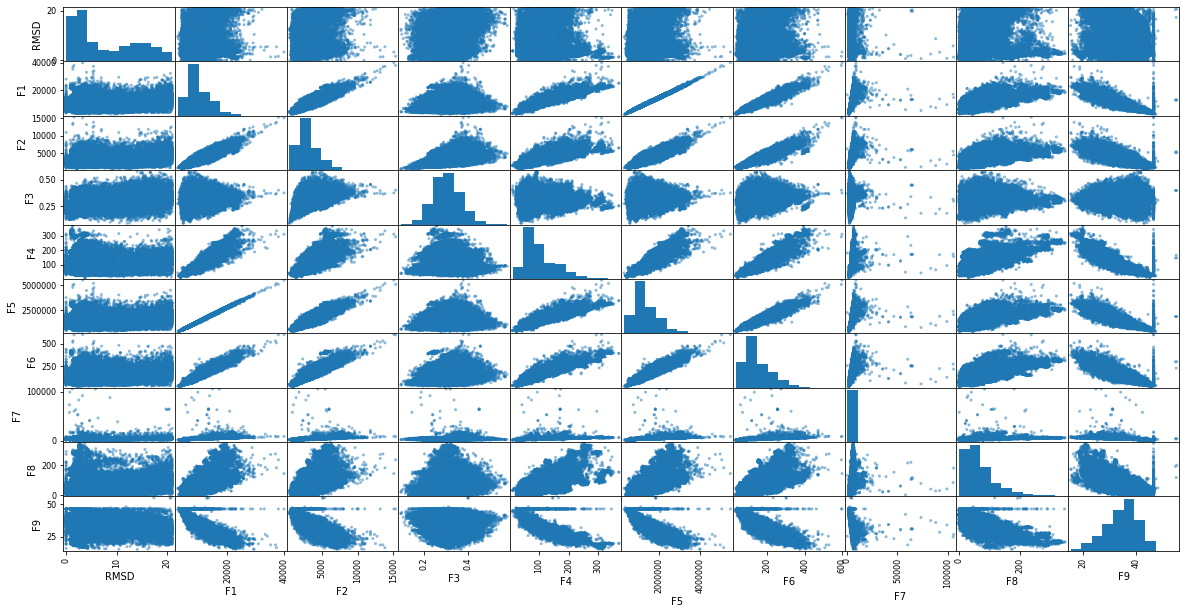

In [9]:
get_correlation(casp)

In [10]:
casp[casp['F7']<7500].corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.373967
F2      0.156547
F9      0.066031
F8     -0.001439
F5     -0.019722
F1     -0.020795
F7     -0.020812
F6     -0.042390
F4     -0.172639
Name: RMSD, dtype: float64

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.999))
])
casp_scaled = scaler_pipeline.fit_transform(casp)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp_scaled[:,1:],casp_scaled[:,0], test_size=0.3, random_state=42)

In [85]:
pca_handle = scaler_pipeline.named_steps['pca']
pca_handle.explained_variance_ratio_.sum()

0.9992204840532481

In [86]:
X_train.shape

(32011, 7)

In [96]:
from sklearn.neural_network import MLPRegressor
import time
mlp_reg = MLPRegressor(random_state=48, max_iter=100, verbose=True);

start_time = time.time()
mlp_reg.fit(X_train, y_train)
print('Time taken ' + str(time.time() - start_time))

Iteration 1, loss = 0.04824981
Iteration 2, loss = 0.03585614
Iteration 3, loss = 0.02656960
Iteration 4, loss = 0.02297296
Iteration 5, loss = 0.02150974
Iteration 6, loss = 0.02062177
Iteration 7, loss = 0.01992326
Iteration 8, loss = 0.01928468
Iteration 9, loss = 0.01885108
Iteration 10, loss = 0.01848637
Iteration 11, loss = 0.01816441
Iteration 12, loss = 0.01793200
Iteration 13, loss = 0.01767294
Iteration 14, loss = 0.01749556
Iteration 15, loss = 0.01732158
Iteration 16, loss = 0.01708412
Iteration 17, loss = 0.01696317
Iteration 18, loss = 0.01674563
Iteration 19, loss = 0.01656427
Iteration 20, loss = 0.01639439
Iteration 21, loss = 0.01623417
Iteration 22, loss = 0.01611511
Iteration 23, loss = 0.01600627
Iteration 24, loss = 0.01583436
Iteration 25, loss = 0.01572019
Iteration 26, loss = 0.01566572
Iteration 27, loss = 0.01551562
Iteration 28, loss = 0.01544358
Iteration 29, loss = 0.01539339
Iteration 30, loss = 0.01534465
Iteration 31, loss = 0.01526393
Iteration 32, los

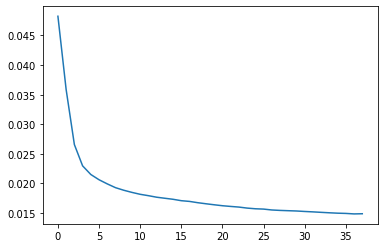

In [97]:
plt.plot(mlp_reg.loss_curve_)

In [98]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(10,6))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [99]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(mlp_reg.predict(X_test),y_test))
rmse_train = np.sqrt(mean_squared_error(mlp_reg.predict(X_train),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  0.171558080205924 0.17577794142672062


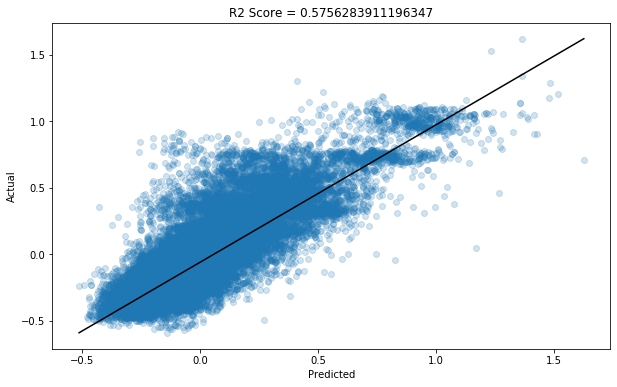

In [101]:
plot_results(X_train, y_train, mlp_reg, "Without_PCA_Train")

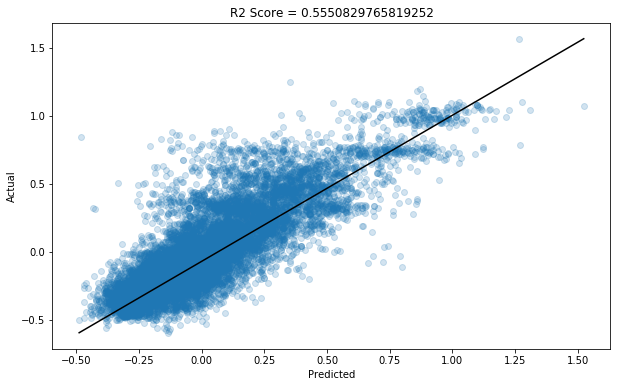

In [102]:
plot_results(X_test, y_test, mlp_reg, "Without_PCA_Test")